In [53]:
import os 

#sys.path.insert(0,"/homes/o23gauvr/Documents/thèse/code/FASCINATION/")
running_path = "/homes/o23gauvr/Documents/thèse/code/FASCINATION/"
os.chdir(running_path)

In [54]:


import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import hydra
import pickle
from src.utils import get_cfg_from_ckpt_path 
from src.select_outputs_on_params import select_outputs_on_params
from sklearn.decomposition import PCA
import numpy as np
import scipy.ndimage
from tqdm import tqdm
from pathlib import Path
import re
from src.utils import *



In [55]:
plt.style.use('ggplot')

In [56]:
cmap = plt.get_cmap('viridis')

In [57]:
gpu = 1
    
if torch.cuda.is_available() and gpu is not None:
##This may not be necessary outside the notebook
    dev = f"cuda:{gpu}"
else:
    dev = "cpu"

device = torch.device(dev)

In [58]:
try:
    if dm_dict:
        print("Not reloading datamodule")

except:
    
    dm_dict = {}
    n_components = 0
    print("Initializing datamodule")

Not reloading datamodule


In [59]:
save_fig = False

In [60]:
load_pca = True

In [61]:
norm = False

In [62]:
with open(f"pickle/rmse_ssp_pca_on_dm_3D_norm_False.pkl", "rb") as file:
    old_pca_rmse_dict = pickle.load(file)  

In [63]:
if load_pca:
    with open(f"pickle/rmse_pca_all_components_with_pooling_upsampling_norm_{norm}_sklearn_pca.pkl", "rb") as file:
        pca_rmse_dict = pickle.load(file)  
        
else:
    pca_rmse_dict = {}
    

In [64]:
pca_n_layers = 1 #Number of layers to keep for the PCA


# Functions

In [65]:
def get_min_max_idx(arr,axs=1):
    grad = np.diff(arr,axis=axs)
    grad_sign = np.sign(grad)
    min_max = np.diff(grad_sign,axis=axs) 
    min_max = np.abs(np.sign(min_max))
    min_max = np.pad(min_max, ((0,0),(1,1),(0,0),(0,0)), 'constant', constant_values=1)
    return min_max


# RMSE

In [66]:

ckpt_dict = {}

base_dir = "outputs/AE/AE_CNN_3D/visualisation/"


# List the first-level directories in the base directory
first_level_dirs = next(os.walk(base_dir))[1]

# Iterate through the first-level directories
for dir_name in first_level_dirs:
    if dir_name == "mute":
        continue
    # Create the relative path
    relative_path = os.path.join(base_dir, dir_name)
    # Add to the dictionary
    ckpt_dict[dir_name] = relative_path

# Print the dictionary
print(ckpt_dict)


{'pred_and_100_grad': 'outputs/AE/AE_CNN_3D/visualisation/pred_and_100_grad', 'pred_loss': 'outputs/AE/AE_CNN_3D/visualisation/pred_loss', 'pred_grad_min_max_loss': 'outputs/AE/AE_CNN_3D/visualisation/pred_grad_min_max_loss', 'pred_loss_elu_none': 'outputs/AE/AE_CNN_3D/visualisation/pred_loss_elu_none'}


In [67]:
for model_carac in ckpt_dict.keys():

    ckpt_list =  list(Path(ckpt_dict[model_carac]).rglob('*.ckpt'))
    print(f"Model {model_carac} with {len(ckpt_list)} checkpoints")

Model pred_and_100_grad with 1 checkpoints
Model pred_loss with 1 checkpoints
Model pred_grad_min_max_loss with 1 checkpoints
Model pred_loss_elu_none with 1 checkpoints


In [68]:
verbose = True


ae_rmse_dict = {"SSP":{},
                "ECS":{},
                "n_min_max":{},
                "ssp_min_max":{}}


        
for model_carac in ckpt_dict.keys():

    ckpt_list =  list(Path(ckpt_dict[model_carac]).rglob('*.ckpt'))


    for ckpt_path in tqdm(ckpt_list):
        ckpt_path = str(ckpt_path)
        
        model_name = " ".join((ckpt_path.split("AE")[-1]).split("/")).replace("_", "  ")
        print(f"\n{model_name}")
        

        if model_carac not in ae_rmse_dict["SSP"].keys():
            for sub_dic in ae_rmse_dict.values():
                sub_dic[model_carac] = {}
        
        
        try:
            cfg = get_cfg_from_ckpt_path(ckpt_path, pprint = False)        
    
        except:
            print(f"Can't load config")
            continue
        
        
        if cfg.datamodule in list(dm_dict.keys()):
            dm = dm_dict[cfg.datamodule]
            test_ssp_arr, _ = loading_datamodule_phase(dm, phase = "test")
            test_ssp_tens = torch.tensor(test_ssp_arr, dtype=getattr(torch,cfg.dtype), device=device)

        
        else:
            if verbose:
                print("Inititing datamodule; Generating train and test datasets")
            
            
            dm = hydra.utils.call(cfg.datamodule)  
            test_ssp_arr, dm = loading_datamodule_phase(dm, phase = "test")
            test_ssp_tens = torch.tensor(test_ssp_arr, dtype=getattr(torch,cfg.dtype), device=device)
            dm_dict[cfg.datamodule] = dm
            


        input_test_shape = test_ssp_tens.shape
        depth_array = dm.depth_array


        
        if verbose:
            print("Loading model, generating AE output")      
        
        try:
            lit_model = load_model(ckpt_path, dm, device, verbose = True)    
        except:
            print(f"Can't load model")
            continue

        ssp_ae_test_arr = lit_model(test_ssp_tens).detach().cpu().numpy().astype(test_ssp_arr.dtype)


        try:
            bottleneck_shape = lit_model.model_AE.bottleneck_shape
        except:
            bottleneck_shape = lit_model.encoder.net(test_ssp_tens.unsqueeze(1)).shape
            
        compression_rate_ae = test_ssp_tens.numel()/bottleneck_shape.numel()

        if bottleneck_shape in ae_rmse_dict["SSP"][model_carac].keys():
            continue

        
        if not norm:
            test_ssp_arr = unorm_ssp_arr_3D(test_ssp_arr, dm)
            ssp_ae_test_arr = unorm_ssp_arr_3D(ssp_ae_test_arr, dm)
            


        max_ssp_truth_idx = np.nanargmax(test_ssp_arr, axis=1)
        ecs_truth = depth_array[max_ssp_truth_idx]

        max_ssp_ae_idx = np.nanargmax(ssp_ae_test_arr, axis=1)
        ecs_pred_ae = depth_array[max_ssp_ae_idx]
            
            
        ae_ssp_rmse = np.sqrt(np.mean((test_ssp_arr - ssp_ae_test_arr)**2))
        ae_ecs_rmse = np.sqrt(np.mean((ecs_truth - ecs_pred_ae)**2))


        min_max_idx_truth = get_min_max_idx(test_ssp_arr)
        min_max_idx_ae = get_min_max_idx(ssp_ae_test_arr)
        mean_error_n_min_max = np.mean(np.abs(min_max_idx_truth-min_max_idx_ae))
        mean_error_ssp_min_max = np.sqrt(np.mean(min_max_idx_truth*(test_ssp_arr-ssp_ae_test_arr)**2))


        
        ae_rmse_dict["SSP"][model_carac][bottleneck_shape] = ae_ssp_rmse
        ae_rmse_dict["ECS"][model_carac][bottleneck_shape] = ae_ecs_rmse
        ae_rmse_dict["n_min_max"][model_carac][bottleneck_shape] = mean_error_n_min_max
        ae_rmse_dict["ssp_min_max"][model_carac][bottleneck_shape] = mean_error_ssp_min_max

            

        if verbose:
            print("bottleneck: ", bottleneck_shape)
            print("cr: ",compression_rate_ae)
     
        



  0%|          | 0/1 [00:00<?, ?it/s]


  CNN  3D visualisation pred  and  100  grad checkpoints val  loss=58.89-epoch=08.ckpt
Loading model, generating AE output


/Odyssey/private/o23gauvr/miniconda3/envs/fsc_env/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:591: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
100%|██████████| 1/1 [00:04<00:00,  4.58s/it]


bottleneck:  torch.Size([37, 8, 64, 87, 120])
cr:  0.8359375


  0%|          | 0/1 [00:00<?, ?it/s]


  CNN  3D visualisation pred  loss lr  0.001 normalization  mean  std manage  nan  suppress n  profiles  None 2025-01-07  16-29 checkpoints val  loss=0.69-epoch=04.ckpt
Loading model, generating AE output


/Odyssey/private/o23gauvr/miniconda3/envs/fsc_env/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:591: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
100%|██████████| 1/1 [00:04<00:00,  4.80s/it]


bottleneck:  torch.Size([37, 8, 64, 87, 120])
cr:  0.8359375


  0%|          | 0/1 [00:00<?, ?it/s]


  CNN  3D visualisation pred  grad  min  max  loss depth  pre  treatment  pca  n  components  10  norm  on  components  train  on  components pooling  Max  on  dim  all channels  [1, 8] upsample  mode  trilinear linear  later  False  lattent  size  50 1  conv  per  layer padding  reflect interp  size  10 final  upsample  upsample act  fn  Elu  final  act  fn  Sigmoid lr  0.001 normalization  mean  std manage  nan  suppress n  profiles  None 2025-01-07  17-22 checkpoints val  loss=52.70-epoch=19.ckpt
Loading model, generating AE output


/Odyssey/private/o23gauvr/miniconda3/envs/fsc_env/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:591: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
100%|██████████| 1/1 [00:04<00:00,  4.91s/it]


bottleneck:  torch.Size([37, 8, 64, 87, 120])
cr:  0.8359375


  0%|          | 0/1 [00:00<?, ?it/s]


  CNN  3D visualisation pred  loss  elu  none lr  0.001 normalization  mean  std manage  nan  suppress n  profiles  None 2025-01-07  16-29 checkpoints val  loss=0.01-epoch=04.ckpt
Loading model, generating AE output


/Odyssey/private/o23gauvr/miniconda3/envs/fsc_env/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:591: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
100%|██████████| 1/1 [00:06<00:00,  6.13s/it]

bottleneck:  torch.Size([37, 8, 64, 87, 120])
cr:  0.8359375


In [69]:
ae_rmse_dict

{'SSP': {'pred_and_100_grad': {torch.Size([37, 8, 64, 87, 120]): 11.601886},
  'pred_loss': {torch.Size([37, 8, 64, 87, 120]): 10.640136},
  'pred_grad_min_max_loss': {torch.Size([37, 8, 64, 87, 120]): 11.503293},
  'pred_loss_elu_none': {torch.Size([37, 8, 64, 87, 120]): 1.0407175}},
 'ECS': {'pred_and_100_grad': {torch.Size([37, 8, 64, 87, 120]): 195.29209701197402},
  'pred_loss': {torch.Size([37, 8, 64, 87, 120]): 66.04355123589856},
  'pred_grad_min_max_loss': {torch.Size([37, 8, 64, 87, 120]): 94.34878835942978},
  'pred_loss_elu_none': {torch.Size([37, 8, 64, 87, 120]): 49.17597014659579}},
 'n_min_max': {'pred_and_100_grad': {torch.Size([37, 8, 64, 87, 120]): 0.061139196},
  'pred_loss': {torch.Size([37, 8, 64, 87, 120]): 0.07022776},
  'pred_grad_min_max_loss': {torch.Size([37, 8, 64, 87, 120]): 0.056648854},
  'pred_loss_elu_none': {torch.Size([37, 8, 64, 87, 120]): 0.051431116}},
 'ssp_min_max': {'pred_and_100_grad': {torch.Size([37, 8, 64, 87, 120]): 2.8316689},
  'pred_los

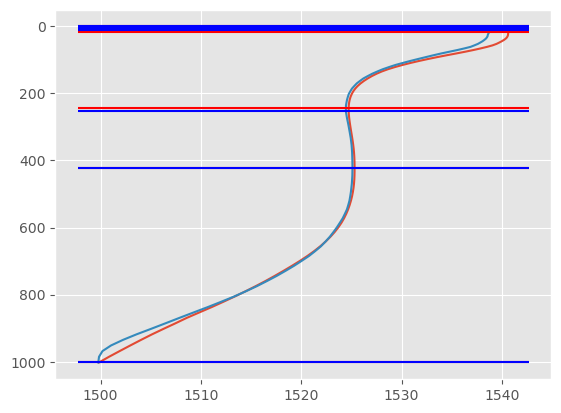

In [70]:


plt.plot(test_ssp_arr[10,:,10,10],dm.depth_array)
plt.plot(ssp_ae_test_arr[10,:,10,10],dm.depth_array)

plt.gca().invert_yaxis()
x_min, x_max = plt.gca().get_xlim()
non_zero_indices_truth = min_max_idx_truth[10,:,10,10] != 0
non_zero_indices_ae = min_max_idx_ae[10,:,10,10] != 0

plt.hlines(min_max_idx_truth[10,:,10,10][non_zero_indices_truth] * dm.depth_array[non_zero_indices_truth], x_min, x_max, colors="r")

plt.hlines(min_max_idx_ae[10,:,10,10][non_zero_indices_ae] * dm.depth_array[non_zero_indices_ae], x_min, x_max, colors="b")



In [71]:
# if not load_pca:
#     train_ssp_arr, _, _, _, _ = loading_datamodule_phase(dm, phase = "fit")
#     input_train_shape = train_ssp_arr.shape

# if bottleneck_shape[2] != n_components and not load_pca:


#     n_components = bottleneck_shape[2]
#     compression_rate_pca = 107/n_components

#     if verbose:
#         print("training PCA, generating PCA output")    
        
#     pca = PCA(n_components = n_components, svd_solver = 'auto')
#     #pca.fit(train_ssp_arr.transpose(0,2,3,1).reshape(-1,107)) 

#     if norm:
#         ssp_pca_test_arr =  pca.inverse_transform(pca.fit_transform(train_ssp_arr.transpose(0,2,3,1).reshape(-1, input_train_shape[1]))).reshape(input_train_shape[0],input_train_shape[2],input_train_shape[3],-1).transpose(0,3,1,2)
    
#     else :
#         ssp_pca_test_arr =  pca.inverse_transform(pca.fit_transform(unorm_ssp_arr_3D(train_ssp_arr).transpose(0,2,3,1).reshape(-1, input_train_shape[1]))).reshape(input_train_shape[0],input_train_shape[2],input_train_shape[3],-1).transpose(0,3,1,2)

#     if ecs_algo == "first_max":
#         ecs_pred_pca = explicit_ecs_3D(torch.tensor(ssp_pca_test_arr).float(),torch.tensor(depth_array).float(), batch = True).detach().cpu().numpy()
    
#     elif ecs_algo == "max":
#         max_ssp_pca_idx = np.nanargmax(ssp_pca_test_arr, axis=1)
#         ecs_pred_pca = depth_array[max_ssp_pca_idx]
        

#     pca_ssp_rmse_dict[n_components] = np.sqrt(np.mean((test_ssp_arr - ssp_pca_test_arr)**2))
    
#     pca_ecs_rmse_dict[n_components]  = np.sqrt(np.mean((ecs_truth - ecs_pred_pca)**2))
    

## add specific model

In [72]:
if dm_dict == {}:
    cfg_path = "config/xp/autoencoder_V2.yaml"
    cfg = OmegaConf.load(cfg_path)
    display(Markdown("""```yaml\n\n""" +yaml.dump(OmegaConf.to_container(cfg), default_flow_style=None, indent=2)+"""\n\n```"""))

    dm = hydra.utils.instantiate(cfg.datamodule)
    #_, test_ssp_tens, dm = loading_datamodule_phase(dm, phase = "test")
    dm.setup("test")

In [73]:

# ae_rmse_dict = {"SSP":{},
#                 "ECS":{}}

# pickle_data_path_list = ["pickle/pooling_upsampling_pca_pre_treatment_rmse_norm_False.pkl"]
# pca_key = [30, 50, 100, 107]
# new_data = {}
# for data_path in pickle_data_path_list:
#     with open(data_path, "rb") as file:
#         new_data = pickle.load(file)

# for key in list(new_data["SSP"].keys()):
#     if any(key.endswith(f"_{num}") for num in pca_key):
#         ae_rmse_dict["SSP"][key] = new_data["SSP"][key]
#         ae_rmse_dict["ECS"][key] = new_data["ECS"][key]


# Plot

In [74]:
components_sorted_ae_rmse_dict = {"SSP":{},
                       "ECS":{},
                       "Filtered SSP": {},
                       "Filtered ECS": {},
                       "ECS max": {},
                       "Filtered ECS max": {}}

for model in ae_rmse_dict["SSP"].keys():
    
    sorted_keys = sorted(ae_rmse_dict["SSP"][model].keys(), key=lambda x: x[2])
    sorted_components = [key[2] if len(key)==5 else key[1] for key in sorted_keys]
    components_sorted_ae_rmse_dict["SSP"][model] = (sorted_components, [ae_rmse_dict["SSP"][model][key] for key in sorted_keys])
    components_sorted_ae_rmse_dict["ECS"][model] = (sorted_components, [ae_rmse_dict["ECS"][model][key] for key in sorted_keys])


pred_and_100_grad
pred_loss


pred_grad_min_max_loss
pred_loss_elu_none


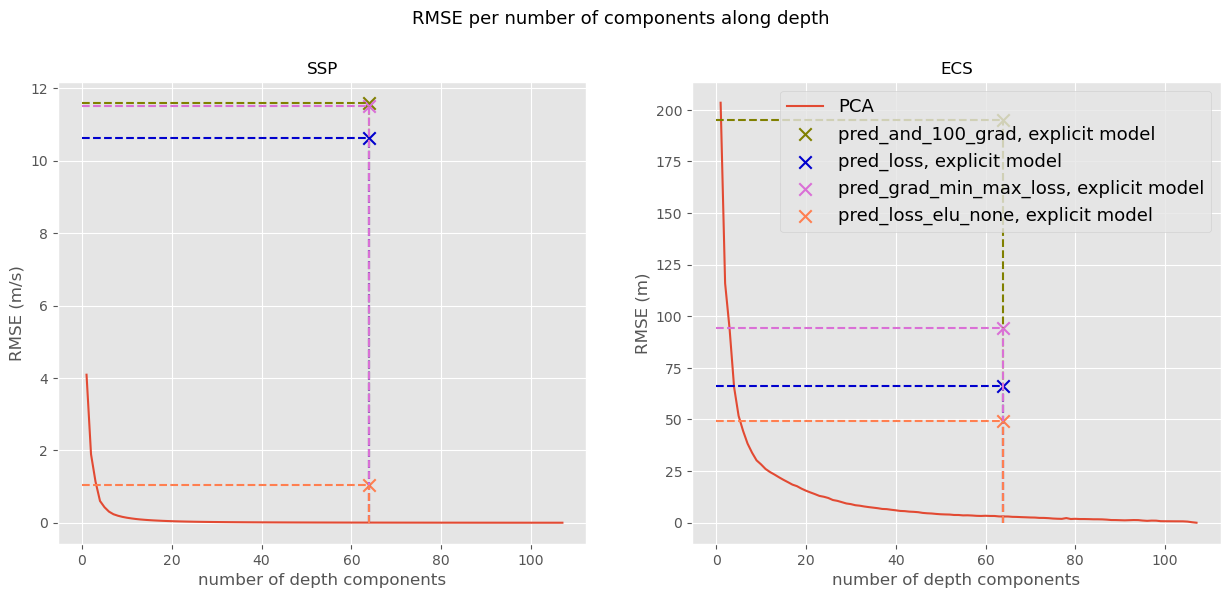

In [75]:

colors = ['olive', 'mediumblue', 'orchid', 'coral',
          'tomato','lightskyblue', 'mediumseagreen',
          'orange','yellowgreen', 'deepskyblue', 'navy', 
          'gold', 'dodgerblue', 'royalblue', 
          ]

fig,axs = plt.subplots(1,2,figsize=(15,6))



for n in range(pca_n_layers):

    if pca_n_layers == 1:
        label = "PCA"
    else:
        label = f"PCA with {n} layers of pooling/upsampling"

    axs[0].plot(pca_rmse_dict["SSP"][f"Pool_upsample_{n}_layers"].keys(),pca_rmse_dict["SSP"][f"Pool_upsample_{n}_layers"].values(), label = label)
    axs[1].plot(pca_rmse_dict["ECS"][f"Pool_upsample_{n}_layers"].keys(),pca_rmse_dict["ECS"][f"Pool_upsample_{n}_layers"].values(), label = label)

i = 0

for model in components_sorted_ae_rmse_dict["SSP"].keys():
        
    
    if len(components_sorted_ae_rmse_dict["SSP"][model][0]) == 1:
        
        print(model)
        
        axs[0].scatter(components_sorted_ae_rmse_dict["SSP"][model][0], components_sorted_ae_rmse_dict["SSP"][model][1], color=colors[i], marker='x', s=80, label = f"{model}")  # s adjusts the cross size
        axs[0].hlines(components_sorted_ae_rmse_dict["SSP"][model][1], xmin=0, xmax=components_sorted_ae_rmse_dict["SSP"][model][0], colors=colors[i], linestyles='dashed')
        axs[0].vlines(components_sorted_ae_rmse_dict["SSP"][model][0], ymin=0, ymax=components_sorted_ae_rmse_dict["SSP"][model][1], colors=colors[i], linestyles='dashed')        

        axs[1].scatter(components_sorted_ae_rmse_dict["ECS"][model][0], components_sorted_ae_rmse_dict["ECS"][model][1], color=colors[i], marker='x', s=80, label = f"{model}, explicit model")  # s adjusts the cross size
        axs[1].hlines(components_sorted_ae_rmse_dict["ECS"][model][1], xmin=0, xmax=components_sorted_ae_rmse_dict["ECS"][model][0], colors=colors[i], linestyles='dashed')
        axs[1].vlines(components_sorted_ae_rmse_dict["ECS"][model][0], ymin=0, ymax=components_sorted_ae_rmse_dict["ECS"][model][1], colors=colors[i], linestyles='dashed')    
        
        i = i+1     
        
    

        
    
    else:

        axs[0].plot(components_sorted_ae_rmse_dict["SSP"][model][0],components_sorted_ae_rmse_dict["SSP"][model][1], c = colors[i], label = f"{model}")
        
        axs[1].plot(components_sorted_ae_rmse_dict["ECS"][model][0], components_sorted_ae_rmse_dict["ECS"][model][1], c = colors[i], label = f"{model} ")

        i=i+1
        



if norm:
    axs[0].set_ylabel("RMSE (normalized)")  
else:    
    axs[0].set_ylabel("RMSE (m/s)")  

axs[0].set_title("SSP", fontsize = 12) 
#axs[0].legend(loc = "upper right", prop={'size': 8})    
    
if norm: 
    axs[1].set_ylabel("RMSE")  
    axs[1].set_title("ECS",fontsize = 12)  
else:   
    axs[1].set_ylabel("RMSE (m)")  
    axs[1].set_title("ECS",fontsize = 12)  


# Adjust the legend size based on the number of labels
handles, labels = axs[1].get_legend_handles_labels()
if len(labels) > 10:
    legend_fontsize = 8
elif len(labels) > 5:
    legend_fontsize = 10
else:
    legend_fontsize = 13

axs[1].legend(prop={'size': legend_fontsize})
        
for ax in axs:
    ax.set_xlabel("number of depth components")
    


    
fig_title = f"RMSE per number of components along depth"
fig.suptitle(fig_title, fontsize = 13, y = 1.0)

if save_fig:
        
    save_name = fig_title.replace(" ", "_").replace(",","").replace("\n","_").replace(":","")
    
    save_name = save_name + f"_normalized_{norm}"
    

    plt.savefig(f"imgs/{save_name}.png", dpi=300, bbox_inches='tight')

In [76]:
pca_cr_dict = {}
for model in pca_rmse_dict["bottleneck_shape"].keys():
    reduced_lat,reduced_lon = pca_rmse_dict["bottleneck_shape"][model][-2:]
    spatial_cr = dm.test_shape[2]*dm.test_shape[3]/(reduced_lat*reduced_lon)
    pca_cr_dict[model] = [spatial_cr*dm.test_shape[1]/n for n in range(1,dm.test_shape[1]+1)] 


In [77]:

cr_sorted_ae_rmse_dict = {"SSP":{},
                       "ECS":{},
                       "Filtered SSP": {},
                       "Filtered ECS": {},
                       "ECS max": {},
                       "Filtered ECS max": {}}

for model in ae_rmse_dict["SSP"].keys():
    
    cr_key_dict = {np.prod(dm.test_shape)/key.numel(): key for key in ae_rmse_dict["SSP"][model].keys()}
    sorted_cr_key = sorted(cr_key_dict.keys())
    
    # sorted_keys = sorted(ae_rmse_dict["SSP"][model].keys(), key=lambda x: x[2])
    # sorted_components = [key[2] for key in sorted_keys]
    cr_sorted_ae_rmse_dict["SSP"][model] = (sorted_cr_key, [ae_rmse_dict["SSP"][model][cr_key_dict[key]] for key in sorted_cr_key])
    cr_sorted_ae_rmse_dict["ECS"][model] = (sorted_cr_key, [ae_rmse_dict["ECS"][model][cr_key_dict[key]] for key in sorted_cr_key])
     


0
pred_and_100_grad
1
pred_loss
2
pred_grad_min_max_loss
3
pred_loss_elu_none


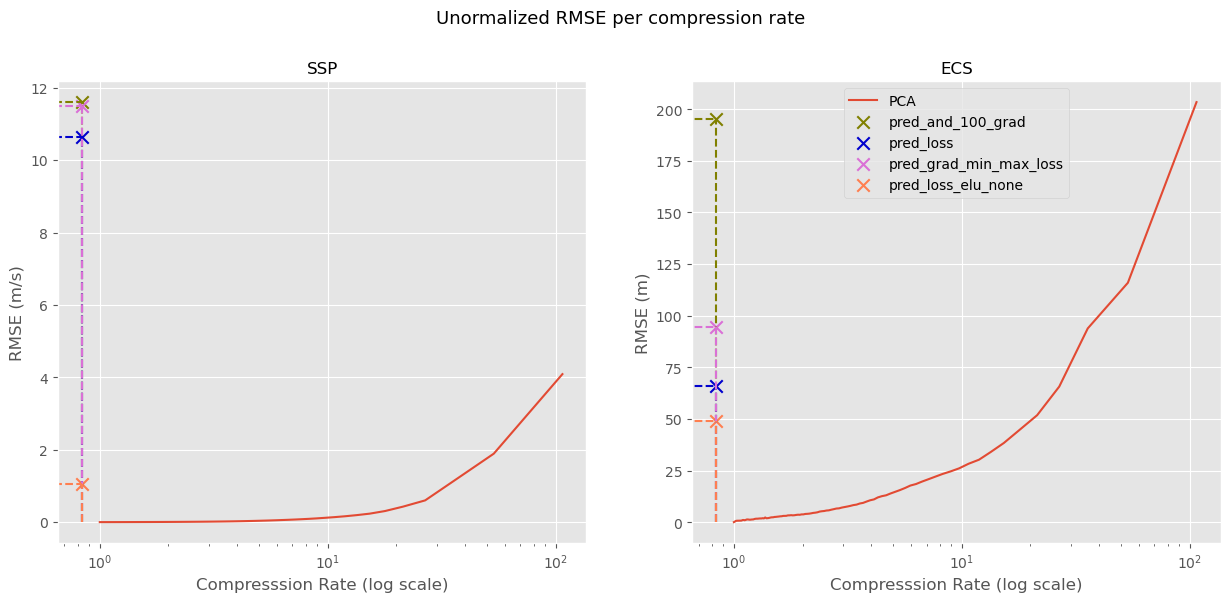

In [78]:
ecs_max = False
filtering = False

colors = ['olive', 'mediumblue', 'orchid', 'coral',
            'gold','lightskyblue', 'mediumseagreen',
            'tomato','yellowgreen', 'deepskyblue', 'navy', 
            'orange', 'dodgerblue', 'royalblue', 
            ]

fig,axs = plt.subplots(1,2,figsize=(15,6))


for n in range(pca_n_layers):
    if pca_n_layers == 1:
        label = "PCA"
    else:
        label = f"PCA with {n} layers of pooling/upsampling"

    axs[0].plot(pca_cr_dict[f"Pool_upsample_{n}_layers"],pca_rmse_dict["SSP"][f"Pool_upsample_{n}_layers"].values(), label = label)
    axs[1].plot(pca_cr_dict[f"Pool_upsample_{n}_layers"],pca_rmse_dict["ECS"][f"Pool_upsample_{n}_layers"].values(), label = label)

i = 0

for model in cr_sorted_ae_rmse_dict["SSP"].keys():
    
    print(i)
    
    
    if len(cr_sorted_ae_rmse_dict["SSP"][model][0]) == 1:
        
        print(model)
        
        axs[0].scatter(cr_sorted_ae_rmse_dict["SSP"][model][0], cr_sorted_ae_rmse_dict["SSP"][model][1], color=colors[i], marker='x', s=80, label = f"{model}")  # s adjusts the cross size
        axs[0].hlines(cr_sorted_ae_rmse_dict["SSP"][model][1], xmin=0, xmax=cr_sorted_ae_rmse_dict["SSP"][model][0], colors=colors[i], linestyles='dashed')
        axs[0].vlines(cr_sorted_ae_rmse_dict["SSP"][model][0], ymin=0, ymax=cr_sorted_ae_rmse_dict["SSP"][model][1], colors=colors[i], linestyles='dashed')        

        axs[1].scatter(cr_sorted_ae_rmse_dict["ECS"][model][0], cr_sorted_ae_rmse_dict["ECS"][model][1], color=colors[i], marker='x', s=80, label = f"{model}")  # s adjusts the cross size
        axs[1].hlines(cr_sorted_ae_rmse_dict["ECS"][model][1], xmin=0, xmax=cr_sorted_ae_rmse_dict["ECS"][model][0], colors=colors[i], linestyles='dashed')
        axs[1].vlines(cr_sorted_ae_rmse_dict["ECS"][model][0], ymin=0, ymax=cr_sorted_ae_rmse_dict["ECS"][model][1], colors=colors[i], linestyles='dashed')    
        
        i=i+1    
        
            


    
    else:

        axs[0].plot(cr_sorted_ae_rmse_dict["SSP"][model][0],cr_sorted_ae_rmse_dict["SSP"][model][1], c = colors[i], label = f"{model}")
        
        axs[1].plot(cr_sorted_ae_rmse_dict["ECS"][model][0], cr_sorted_ae_rmse_dict["ECS"][model][1], c = colors[i], label = f"{model}")

        i=i+1
        
        
        if ecs_max:
            axs[1].plot(cr_sorted_ae_rmse_dict["ECS max"][model][0], cr_sorted_ae_rmse_dict["ECS max"][model][1], c = colors[i], label = f"{model} max algo")

            i=i+1
            

                




axs[0].set_title("SSP", fontsize = 12) 
#axs[0].legend(loc = "upper left", prop={'size': 8})    


if norm: 
    axs[0].set_ylabel("RMSE")  
    axs[1].set_ylabel("RMSE")  
    axs[1].set_title("ECS",fontsize = 12)  
    fig_title = f"Normalized RMSE per compression rate"
    
else:   
    axs[0].set_ylabel("RMSE (m/s)")  
    axs[1].set_ylabel("RMSE (m)")  
    axs[1].set_title("ECS",fontsize = 12)  
    fig_title = f"Unormalized RMSE per compression rate"


    # Adjust the legend size based on the number of labels
    handles, labels = axs[1].get_legend_handles_labels()
    if len(labels) > 10:
        legend_fontsize = 7
    elif len(labels) > 5:
        legend_fontsize = 8
    else:
        legend_fontsize = 10

    axs[1].legend(prop={'size': legend_fontsize})
            
for ax in axs:

    ax.set_xlabel("Compresssion Rate (log scale)")
    ax.set_xscale("log")
    


    

fig.suptitle(fig_title, fontsize = 13, y = 1.0)

if save_fig:
        
    save_name = fig_title.replace(" ", "_").replace(",","").replace("\n","_").replace(":","")
    
    save_name = save_name + f"_normalized_{norm}"
    

    plt.savefig(f"imgs/{save_name}.png", dpi=300, bbox_inches='tight')